In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers, models
import numpy as np

In [ ]:
(ds_train, ds_val, ds_test), ds_info = tfds.load(
    'beans',
    split=['train', 'validation', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/1034 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteCPMHOC/beans-train.tfrecord*...:   0%|          | 0/…

Generating validation examples...:   0%|          | 0/133 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteCPMHOC/beans-validation.tfrecord*...:   0%|         …

Generating test examples...:   0%|          | 0/128 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/beans/0.1.0.incompleteCPMHOC/beans-test.tfrecord*...:   0%|          | 0/1…

Dataset beans downloaded and prepared to /root/tensorflow_datasets/beans/0.1.0. Subsequent calls will reuse this data.


In [ ]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    image = tf.image.random_contrast(image, lower=0.9, upper=1.1)
    image = tf.image.random_hue(image, max_delta=0.1)
    image = tf.image.random_saturation(image, lower=0.9, upper=1.1)
    return image, label

In [ ]:
def normalize_img(image, label):
    """Normalizes images: `uint8` -> `float32`."""
    return tf.cast(image, tf.float32) / 255., label

# Apply data augmentation and normalization to the training set
ds_train = ds_train.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_train = ds_train.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

# Only normalize validation and test datasets
ds_val = ds_val.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)
ds_test = ds_test.map(normalize_img, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [ ]:
# Batch and prefetch the datasets
BATCH_SIZE = 32

ds_train = ds_train.cache().shuffle(ds_info.splits['train'].num_examples).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
ds_val = ds_val.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE)
ds_test = ds_test.batch(BATCH_SIZE).cache().prefetch(tf.data.experimental.AUTOTUNE)

In [ ]:
# Build the model
model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(3, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 249, 249, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 123, 123, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 121, 121, 128)     73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 60, 60, 128)       0

In [ ]:
EPOCHS = 10
history = model.fit(
    ds_train,
    epochs=EPOCHS,
    validation_data=ds_val
)

Epoch 1/10
33/33 [==============================] - 38s 416ms/step - loss: 2.0619 - accuracy: 0.3859 - val_loss: 1.0323 - val_accuracy: 0.3910
Epoch 2/10
33/33 [==============================] - 9s 254ms/step - loss: 0.9059 - accuracy: 0.5677 - val_loss: 0.6971 - val_accuracy: 0.7143
Epoch 3/10
33/33 [==============================] - 8s 246ms/step - loss: 0.7011 - accuracy: 0.7070 - val_loss: 0.9971 - val_accuracy: 0.6165
Epoch 4/10
33/33 [==============================] - 8s 254ms/step - loss: 0.6955 - accuracy: 0.7089 - val_loss: 0.6050 - val_accuracy: 0.7669
Epoch 5/10
33/33 [==============================] - 8s 254ms/step - loss: 0.5452 - accuracy: 0.7698 - val_loss: 0.6484 - val_accuracy: 0.6992
Epoch 6/10
33/33 [==============================] - 8s 253ms/step - loss: 0.4473 - accuracy: 0.8153 - val_loss: 0.7594 - val_accuracy: 0.6241
Epoch 7/10
33/33 [==============================] - 8s 248ms/step - loss: 0.3549 - accuracy: 0.8588 - val_loss: 0.9157 - val_accuracy: 0.6316
Epoch

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# Importing Evaluation matrces
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay

In [ ]:
y_test = []
y_pred = []

for image, label in ds_test:
    y_test.extend(label.numpy())
    predictions = model.predict(image)
    y_pred.extend(np.argmax(predictions, axis=1))

1/1 [==============================] - 0s 108ms/step


Accuracy :  0.71875
--------------------------------------------------
F1 :  [0.69902913 0.63013699 0.825     ]
--------------------------------------------------
Reacll :  [0.8372093  0.53488372 0.78571429]
--------------------------------------------------
Precision :  [0.6        0.76666667 0.86842105]
--------------------------------------------------
Confusion Matrix....
 [[36  5  2]
 [17 23  3]
 [ 7  2 33]]
--------------------------------------------------
Classification Report....
               precision    recall  f1-score   support

           0       0.60      0.84      0.70        43
           1       0.77      0.53      0.63        43
           2       0.87      0.79      0.82        42

    accuracy                           0.72       128
   macro avg       0.75      0.72      0.72       128
weighted avg       0.74      0.72      0.72       128

--------------------------------------------------
Plotting Confusion Matrix...



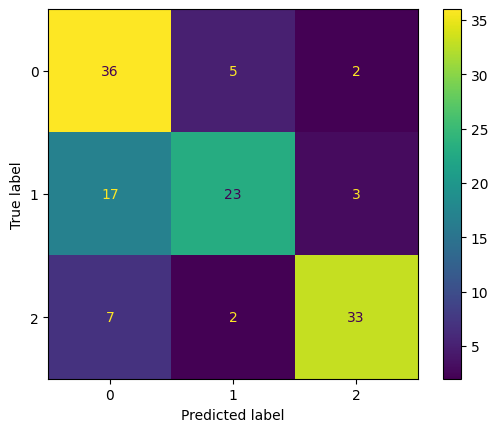

In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)

# Precision
precision = precision_score(y_test, y_pred, average=None)

# Recall
recall = recall_score(y_test, y_pred, average=None)

# F1 Score
f1_sco = f1_score(y_test, y_pred, average=None)

# Confusion Matrix
confusion_mat = confusion_matrix(y_test, y_pred)

# Report
report = classification_report(y_test, y_pred)

print('Accuracy : ', accuracy)
print("-"*50)
print('F1 : ', f1_sco)
print("-"*50)
print('Reacll : ', recall)
print("-"*50)
print('Precision : ', precision)
print("-"*50)
print('Confusion Matrix....\n', confusion_mat)
print("-"*50)
print('Classification Report....\n', report)
print("-"*50)
print('Plotting Confusion Matrix...\n')
disp = ConfusionMatrixDisplay(confusion_mat, display_labels=None)
disp.plot()
plt.show()